# IMPORTS

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from cv2 import imread
import scipy
from skimage.morphology import opening, disk, closing
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage


from __future__ import print_function
import cv2
from pylab import *
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
from skimage.morphology import disk, opening


[[183.          33.        ]
 [182.99802213  33.62894333]
 [182.99208861  34.25786178]
 ...
 [182.99208861  31.74213822]
 [182.99802213  32.37105667]
 [183.          33.        ]]


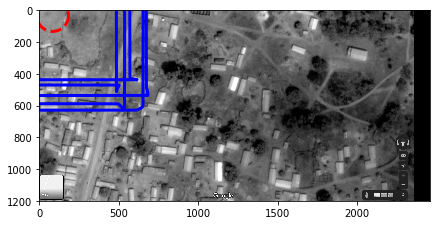

In [3]:


# Bilate filtered image. Sharpened image helps to give a better edge approximation.
img = imread('1_cropped.png')
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 1000)
x = 83 + 100*np.cos(s)
y = 33 + 100*np.sin(s)
init = np.array([x, y]).T
print (init)
'''
alpha Higher values make snake contract faster
beta Highervalue make snake smoother
Gamma Timestepping parameter
'''
snake = active_contour(img, init, alpha=-1, beta=7, gamma=0.001, max_iterations=500)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.gray()
ax.imshow(img)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
# ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
# plt.imshow(img, cmap='gray')
plt.show()

In [5]:

def equalize(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img


def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

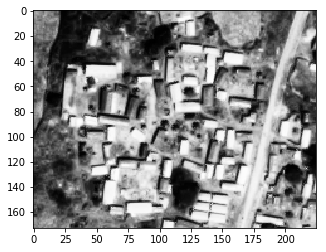

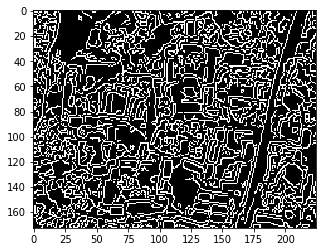

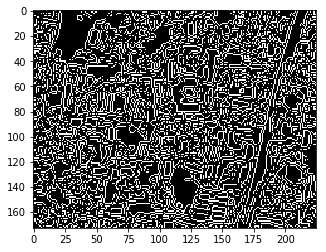

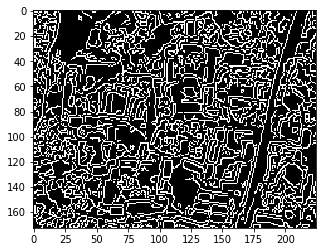

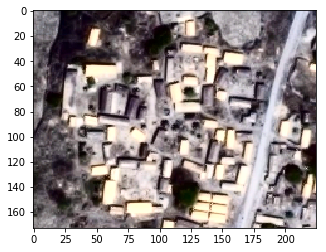

In [16]:
eq = imread('7_cropped.png')
x=equalize(eq)
gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
kernel_sharp = np.array((
         [-2, -2, -2],
         [-2, 17, -2],
         [-2, -2, -2]), dtype='int')



auto2 = auto_canny(x)
im1=cv2.filter2D(auto2, -1, kernel=kernel_sharp)
canny = auto_canny(im1)
plt.figure()
plt.imshow(auto2, cmap='gray')
plt.show()
plt.imshow(canny, cmap='gray')
plt.show()
plt.imshow(im1, cmap='gray')
plt.show()

plt.imshow(im_eq, cmap='gray')
plt.show()

[[183.          33.        ]
 [182.99802213  33.62894333]
 [182.99208861  34.25786178]
 ...
 [182.99208861  31.74213822]
 [182.99802213  32.37105667]
 [183.          33.        ]]


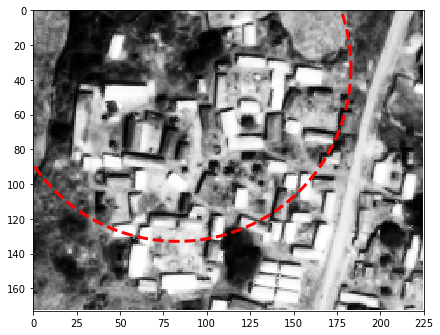

In [19]:
img = rgb2gray(eq)

s = np.linspace(0, 2*np.pi, 1000)
x = 83 + 100*np.cos(s)
y = 33 + 100*np.sin(s)
init = np.array([x, y]).T
print (init)
'''
alpha Higher values make snake contract faster
beta Highervalue make snake smoother
Gamma Timestepping parameter
'''
snake = active_contour(img, init, alpha=-1, beta=7, gamma=0.001, max_iterations=500)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.gray()
ax.imshow(img)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
# ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
# plt.imshow(img, cmap='gray')
plt.show()


In [27]:

def createLineIterator(P1, P2, im):
    """
    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])
    """
    imageH = im.shape[0]
    imageW = im.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    # difference and absolute difference between points
    # used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    # predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa, dXa), 3), dtype=np.float32)
    itbuffer.fill(np.nan)

    # Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X:  # vertical line segment
        itbuffer[:, 0] = P1X
        if negY:
            itbuffer[:, 1] = np.arange(P1Y - 1, P1Y - dYa - 1, -1)
        else:
            itbuffer[:, 1] = np.arange(P1Y + 1, P1Y + dYa + 1)
    elif P1Y == P2Y:  # horizontal line segment
        itbuffer[:, 1] = P1Y
        if negX:
            itbuffer[:, 0] = np.arange(P1X - 1, P1X - dXa - 1, -1)
        else:
            itbuffer[:, 0] = np.arange(P1X + 1, P1X + dXa + 1)
    else:  # diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = float(dX) / float(dY)
            if negY:
                itbuffer[:, 1] = np.arange(P1Y - 1, P1Y - dYa - 1, -1)
            else:
                itbuffer[:, 1] = np.arange(P1Y + 1, P1Y + dYa + 1)
            itbuffer[:, 0] = (slope * (itbuffer[:, 1] - P1Y)).astype(np.int) + P1X
        else:
            slope = float(dY) / float(dX)
            if negX:
                itbuffer[:, 0] = np.arange(P1X - 1, P1X - dXa - 1, -1)
            else:
                itbuffer[:, 0] = np.arange(P1X + 1, P1X + dXa + 1)
            itbuffer[:, 1] = (slope * (itbuffer[:, 0] - P1X)).astype(np.int) + P1Y

    # Remove points outside of image
    colX = itbuffer[:, 0]
    colY = itbuffer[:, 1]
    itbuffer = itbuffer[(colX >= 0) & (colY >= 0) & (colX < imageW) & (colY < imageH)]

    # Get intensities from img ndarray
    itbuffer[:, 2] = im[itbuffer[:, 1].astype(np.uint), itbuffer[:, 0].astype(np.uint)]

    return itbuffer



In [30]:

im = eq
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)   # 1st image use
# img = cv2.bitwise_not(img)

rows, cols = img.shape
white_img = cv2.bitwise_not(np.zeros(im.shape, np.uint8))
white_polygon = cv2.bitwise_not(np.zeros(im.shape, np.uint8))
white_gray = cv2.cvtColor(white_img, cv2.COLOR_BGR2GRAY)

v = np.median(img)
sigma = 0.33
lower_thresh = int(max(0, (1.0 - sigma) * v))
upper_thresh = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(img, lower_thresh, upper_thresh)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 30)
lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))

kmeans = KMeans(n_clusters=20).fit(lines)

for line in kmeans.cluster_centers_:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)
    cv2.line(white_gray, (x1, y1), (x2, y2), 0, 2)

    pixels = createLineIterator((x1, y1), (x2, y2), img)
    pixels = pixels.astype(int)
    pixel_len = len(pixels)

    for i in range(pixel_len):
        x, y, intensity = pixels[i]
        if 0 < y < rows - 1 and 0 < x < cols - 1:
            # patch = edges[x - k_row/2: x + k_row/2,
            #         y - k_col/2: y + k_col/2]
            sum_patch = edges[y, x] + edges[y - 1, x] + edges[y + 1, x] + edges[y, x - 1] + edges[y - 1, x - 1] + edges[
                y + 1, x - 1] + edges[y, x + 1] + edges[y - 1, x + 1] + edges[y + 1, x + 1]
            if sum_patch > 0:
                img[y, x] = 255
    
x1 = []
y1 = []
m = np.sort(m)
c = np.sort(c)
print (m, c)
for i in range(len(m)-1):
    for j in range(len(c)-1):
        if m[i] - m[i+1] != 0:
            x = ((c[j + 1] - c[j]) / (m[i] - m[i + 1]))
            y = (((m[i]*c[i+1]) - (m[i+1]*c[j])) / (m[i] - m[i+1]))
            if 0 < x < cols and 0 < y < rows:
                x1.append(x)
                y1.append(y)
x1 = np.array(x1)
y1 = np.array(y1)
intersect = (np.column_stack((x1, y1)))
print (intersect)


for i, j, k in zip(r, c, s):
    r[i] = x1*c[j] + y1*s[k]

contours = cv2.findContours(white_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

for cnt in contours:
    cv2.drawContours(white_polygon, cnt, 0, 0, -1)
    man = []
    intense = []
    for col in range(cols):
        for row in range(rows):
            if cv2.pointPolygonTest(cnt, (col, row), False) == 1:
                man.append((row, col))
    for k in man:
        intense.append(im[k])
    intensity = mean(intense)
    # print (intensity)
    if intensity > 170:
        cv2.drawContours(white_polygon, [cnt], 0, 0, -1)

    # mean_val = np.mean(cnt)
    # if mean_val < 120:
    #     img[cnt] = 255
# man = map(int, man)
# for i, j in zip(contours, man):
#     if j < 90:
#         cv2.drawContours(img, i, 0, thickness=-1, color=0)
#     else:
#         cv2.drawContours(img, i, 0, thickness=-1, color=255)
# for cnt in contours:
#     cv2.drawContours(im, [cnt], 0, 0, -1)
white_gray1 = cv2.cvtColor(white_polygon, cv2.COLOR_BGR2GRAY)
opened = opening(white_gray1, selem=disk(4))
# kernel_sharp = np.array((
#          [-2, -2, -2],
#          [-2, 17, -2],
#          [-2, -2, -2]), dtype='int')
# opens = cv2.filter2D(opened, -1, kernel_sharp)
opened = Image.fromarray(opened)
opened.save('opened.png')
plt.imshow(opened, cmap='gray')
plt.show()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in ubyte_scalars


NameError: name 'm' is not defined

In [19]:



def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged


def equalize(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img

In [29]:
def equalize(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img


[INFO] 257 unique segments found


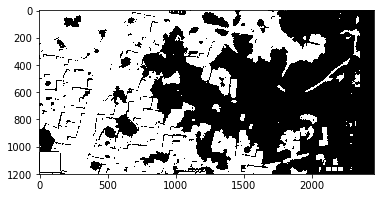

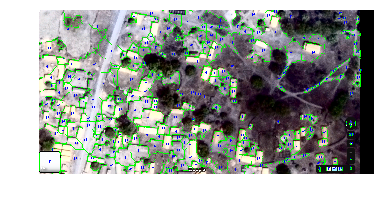

In [34]:


# load the image and perform pyramid mean shift filtering to aid the thresholding step
image = cv2.imread('1_cropped.png')
im = equalize(image)
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

# convert the mean shift image to grayscale, then apply
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# the [1] in the last means take only the image and discard the threshold value
# cv2.thresh_binary+cv2.otsu is same as cv2.thresh_binary|cv2.thresh_otsu
plt.imshow(thresh, cmap=plt.get_cmap('gray'))

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
                          labels=thresh)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    # c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    # ((x, y), r) = cv2.minEnclosingCircle(c)
    # cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    # cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
    # cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # loop over the contours
    for (i, c) in enumerate(cnts):
        # draw the contour
        ((x, y), _) = cv2.minEnclosingCircle(c)
        cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

plt.figure()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

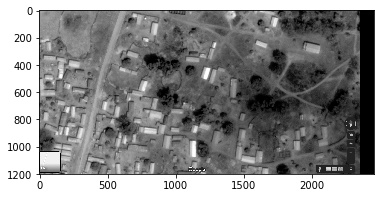

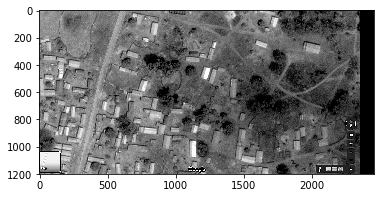

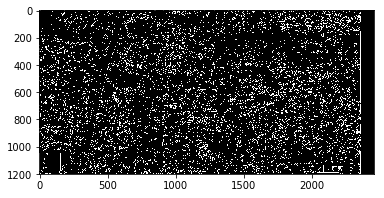

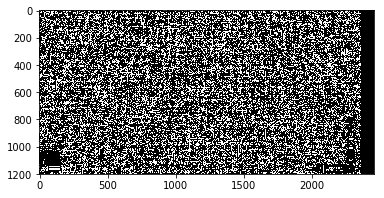

In [27]:



# 28.539901_77.205472.png
img = cv2.imread('1_cropped.png')
# imm = equalize(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
blur = cv2.bilateralFilter(gray, 5, 75, 75)
kernel_sharp = np.array((
         [-2, -2, -2],
         [-2, 17, -2],
         [-2, -2, -2]), dtype='int')
im = cv2.filter2D(blur, -1, kernel_sharp)
plt.figure()
plt.imshow(im, cmap='gray')
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
laplacian = laplacian.clip(min=0)
x = laplacian.astype(np.uint8)
auto2 = auto_canny(x)
im1=cv2.filter2D(auto2, -1, kernel=kernel_sharp)
canny = auto_canny(im)
plt.figure()
plt.imshow(canny, cmap='gray')
plt.show()
plt.imshow(im1, cmap='gray')
plt.show()

[[117 116 116 ... 123 123 126]
 [112 111 111 ... 124 125 126]
 [108 106 107 ... 125 125 125]
 ...
 [ 86  95 109 ...  57  63  66]
 [ 87  96 109 ...  57  61  63]
 [ 88  96 110 ...  60  60  61]]
[[ 2.  2.  2. ...  2.  7.  2.]
 [ 2.  2.  2. ...  2.  2.  2.]
 [ 2.  8.  4. ...  2.  2.  2.]
 ...
 [17.  4.  3. ...  2.  2.  2.]
 [18.  3.  7. ...  6.  2.  2.]
 [14.  6.  3. ...  2.  3.  2.]]
[[ 2  2  2 ...  2  7  2]
 [ 2  2  2 ...  2  2  2]
 [ 2  8  4 ...  2  2  2]
 ...
 [17  4  3 ...  2  2  2]
 [18  3  7 ...  6  2  2]
 [14  6  3 ...  2  3  2]]


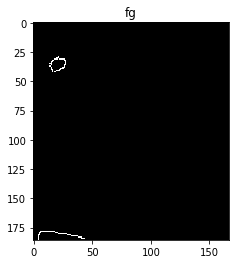

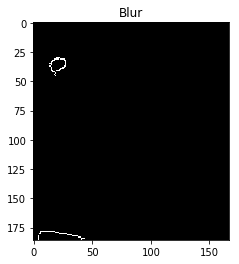

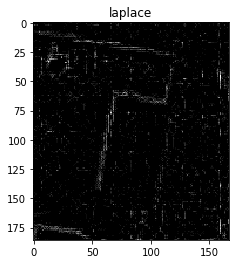

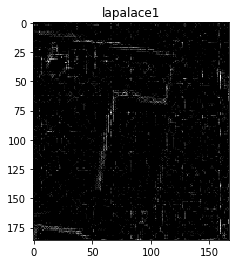

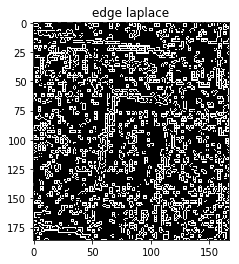

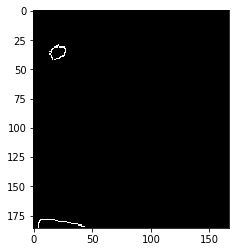

[[133 144 149 153 156 158 158 158 155 149 140 129 117 108 105 104 101  94
   96 104 106 104 105 109 109 109]
 [126 140 144 148 152 156 156 155 155 155 147 136 124 113 106  99  94  89
   94 102 104 105 106 109 109 109]
 [123 134 139 146 150 152 152 155 155 155 149 139 128 118 107  94  86  88
   95 104 108 108 107 109 104 103]
 [117 131 141 146 150 152 152 153 152 150 147 139 129 118 109  97  93  94
  108 115 116 114 109 110 104 101]
 [124 132 145 148 152 154 154 151 146 145 137 129 122 115 111 104 100 100
  111 117 122 118 115 113  99  92]
 [136 140 146 150 150 148 147 150 145 139 104 107  91  93  95  97  99 106
  118 120 123 121 115 112 103 105]
 [139 142 144 149 150 150 150 148 149 127  87  91  89  88  89  90  98 104
  124 124 124 123 119 114 112 117]
 [139 141 144 148 149 150 152 149 149 117 117 136 139 139 140 139 141 134
  131 124 129 131 125 115 113 114]
 [144 145 144 148 146 146 147 146 141 109 111 165 185 194 207 207 197 192
  181 175 160 137 130 124 121 121]
 [141 142 145 146 1

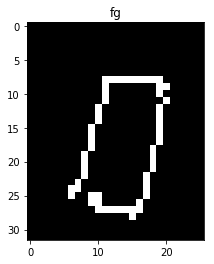

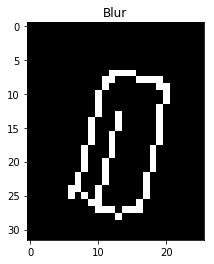

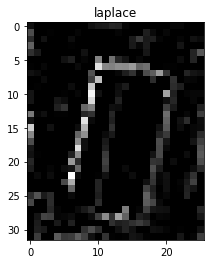

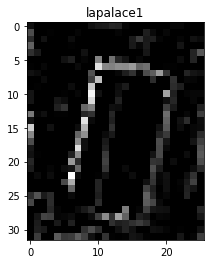

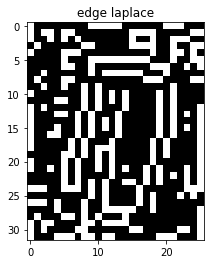

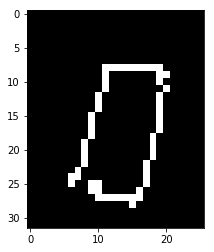

[[123 127 132 ...  89  90  94]
 [124 126 128 ...  90  91  95]
 [126 124 125 ...  90  92  95]
 ...
 [132 129 126 ... 136 136 136]
 [129 128 126 ... 136 137 136]
 [126 126 126 ... 136 138 137]]
[[10.  2.  2. ...  2.  5.  2.]
 [ 5.  2.  2. ...  2.  3.  2.]
 [ 2.  3.  2. ...  2.  2.  2.]
 ...
 [ 2.  2.  2. ...  2.  2.  2.]
 [ 2.  2.  2. ...  2.  2.  3.]
 [ 6.  4.  2. ...  2.  2.  2.]]
[[10  2  2 ...  2  5  2]
 [ 5  2  2 ...  2  3  2]
 [ 2  3  2 ...  2  2  2]
 ...
 [ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  3]
 [ 6  4  2 ...  2  2  2]]


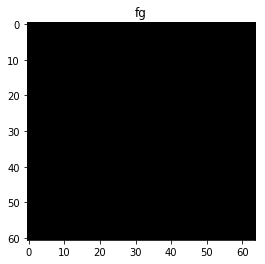

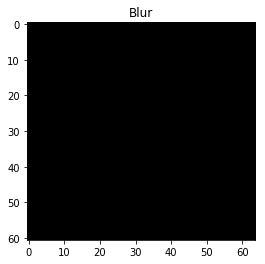

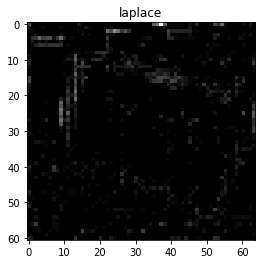

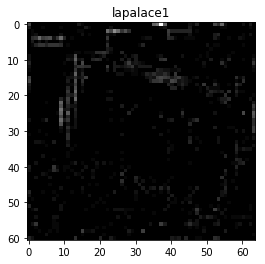

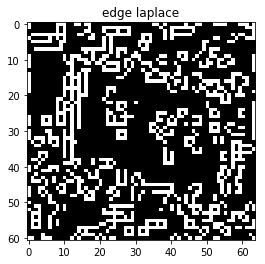

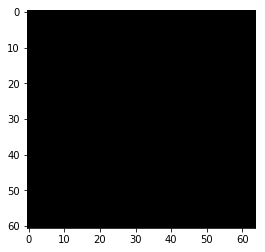

In [17]:

images = [imread('3_cropped.png'),imread('3_cropped.png'),imread('4_cropped.png')]

# loop over the images
for image in images:
    # load the image, convert it to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print (gray)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    fg = cv2.addWeighted(blurred, 1.5, gray, -0.5, 0)
    kernel_sharp = np.array((
        [-1, -1, -1],
        [-1, 9, -1],
        [-1, -1, -1]), dtype='int')
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = laplacian.clip(min=0)
    print (laplacian)
    auto = auto_canny(fg)
    auto1 = auto_canny(blurred)
    im = cv2.filter2D(auto, -1, kernel_sharp)
    # dst = cv2.addWeighted(gray, 0.5, auto, 0.5, 0)
    # dst1 = cv2.addWeighted(gray, 0.5, auto1, 0.5, 0)
    x = laplacian.astype(np.uint8)
    print (x)
    auto2 = auto_canny(x)
    im1 = cv2.filter2D(auto2, -1, kernel=kernel_sharp)

    plt.figure()
    plt.title("fg")
    plt.imshow(auto, cmap='gray')
    plt.figure()
    plt.title("Blur")
    plt.imshow(auto1, cmap='gray')
    plt.figure()
    plt.title("laplace")
    plt.imshow(laplacian, cmap='gray')
    plt.figure()
    plt.title("lapalace1")
    plt.imshow(x, cmap='gray')
    plt.figure()
    plt.title("edge laplace")
    plt.imshow(im1, cmap='gray')
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()

plt.figure("Original")
plt.close()
plt.figure("Nothing")
plt.close()
plt.figure("Blur/Smooth")
plt.close()


# CONCTION TO GOOGLE DRIVE

In [2]:
import gspread
import httplib2
import os, io
import argparse
import auth


from httplib2 import Http
from oauth2client import file,client, tools
from googleapiclient import discovery
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client.service_account import ServiceAccountCredentials

SCOPES = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive.file',
         'https://www.googleapis.com/auth/spreadsheets.currentonly',
         'https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/presentations',
         'https://www.googleapis.com/auth/drive.scripts',
         'https://www.googleapis.com/auth/drive.appdata',
         'https://www.googleapis.com/auth/drive.metadata'
        ]
store = file.Storage('storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('client_id.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))

# Global variables

Folder to upload files

In [3]:
drive_folder='12nPlS3tkFe5z-r-jobf9jJi-LbMDkzV6'

# Functions

function to uplad files to google drive

In [4]:
'''
filename -> name of the file in drive
filepath -> path of the local file
folder_id -> id of the drive folder where you want to put the file 
filetype -> text/csv
fileapp: application/vnd.google-apps.spreadsheet
'''

def uploadFile(filename,filepath,folder_id,filetype,fileapp):    
    file_metadata = { 'name': filename,
                      'parents': [folder_id],
                      'mimeType': fileapp,
                    }  
                                                  
                             

    media = MediaFileUpload(filepath,
                            mimetype=filetype)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()

In [5]:
def crop(image_path, coords, saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)
    cropped_image.show()

# Open Chrome

In [6]:
#driver.close()

In [7]:
driver = webdriver.Chrome(executable_path=r'/Users/5danalfaro/Nikarit/YouTube2/chromedriver')

# square

In [8]:
# upper left corner
u_l_c={
'lat':10.2373265,
'long':2.7572038
} 
# upper right corner
u_r_c={
'lat':10.2373265,
'long':3.6937883
} 
# lower right corner
l_r_c={
'lat':9.600178,
'long':3.6937883
} 
# lower left corner
l_l_c={
'lat':9.600178,
'long':2.7572038
} 

In [13]:
104/111.111 

0.9360009360009359

In [28]:
horizontal=((u_r_c['long']-u_l_c['long'])*111.111)*1000/size

In [29]:
vertical=((u_r_c['lat']-l_r_c['lat'])*111.111)*1000/size

In [30]:
horizontal*vertical

11511.231014892526

In [53]:
size=800
lat=10.0644685
long=2.8327505

In [54]:
url=('''https://www.google.com/maps/@'''+
     str(lat)+','+str(long)+''','''+str(size)+'''m/data=!3m1!1e3'''
     )

In [55]:
driver.get(url)

In [16]:
driver.implicitly_wait(1000)

In [21]:
driver.find_elements_by_class_name('widget-pane-toggle-button')[0].click()

In [20]:
driver.find_elements_by_class_name('widget-consent-button-later')[0].click()

In [22]:
driver.save_screenshot('1_example.png')

True

In [23]:
crop('1_example.png',(40, 100, 2500, 1300),'1_cropped.png')

In [140]:
()*111111

1364.0875247999975

In [127]:
lat=lat+600/111111
long=2.8327505

In [133]:
crop('2_example.png',(40, 100, 2500, 1300),'2_cropped.png')

In [27]:
urls=[]

In [28]:

urls.append('''https://www.google.com/maps/@'''+
     str(lat)+','+str(long)+''','''+str(size)+'''m/data=!3m1!1e3'''
     )
lat=10.0644685
long=2.8423642
urls.append('''https://www.google.com/maps/@'''+
     str(lat)+','+str(long)+''','''+str(size)+'''m/data=!3m1!1e3'''
     )

In [ ]:
2.8416235000900003

In [63]:
2.8416235000900003+10/111111

2.8417135001800005

In [66]:
lat=10.0644685
long=2.8327505
for i in range(6):
    url=('''https://www.google.com/maps/@'''+
     str(lat)+','+str(long)+''','''+str(size)+'''m/data=!3m1!1e3'''
     )
    driver.get(url)
    driver.implicitly_wait(5000)
    time.sleep(2)
    driver.find_elements_by_class_name('widget-pane-toggle-button')[0].click()
    driver.find_elements_by_class_name('widget-consent-button-later')[0].click()
    driver.save_screenshot(str(i)+'_example.png')
    a=crop(str(i)+'_example.png',(40, 100, 1200, 800),str(i)+'_cropped.png')
    long=long+(2.8417135001800005-2.8327505)

In [ ]:
lat=10.0644685
long=2.8327505

url=('''https://www.google.com/maps/@'''+
     str(lat)+','+str(long)+''','''+str(size)+'''m/data=!3m1!1e3'''
     )

driver.get(url)

driver.find_elements_by_class_name('widget-pane-toggle-button')[0].click()

driver.find_elements_by_class_name('widget-consent-button-later')[0].click()

driver.save_screenshot('example_2.png')

def crop(image_path, coords, saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)
    cropped_image.show()

crop('example.png',(40, 100, 1200, 1354),'cropped_3.png')

In [38]:
#click = driver.find_element_by_xpath('button')

# SECOND TRY

In [ ]:
url=(https://www.google.com/maps/d/edit?mid=1MtbdRCmYDSSSWThGlJ_ZYkJhvRczLeBl&ll=10.115439676958355%2C2.8987132496481536&z=18)


# Get each table and save the info in drive

In [644]:
#Loop to every option and get each table
for j in range(len(s1.options)):
    #there is no info in the first option
    if(j==0):
        continue
    #every iteration get the page again
    driver.get("https://podapp.industriales.upm.es/web/horarios.php")
    #wait until information is shown up and select the dropdown
    driver.implicitly_wait(1000)
    s1= Select(driver.find_element_by_id('titulacion-select'))
    driver.implicitly_wait(1000)
    
    #get the info of that dropdown
    clase=s1.options[j].text
    print(clase)
    
    #create a folder with this name
    clase_folder=CreateFolder(clase, drive_folder)
    driver.implicitly_wait(1000)
    
    #select the dropdown with that index
    s1.select_by_index(j)
    driver.implicitly_wait(2000)
    
    #get all the tables of the page
    tables=driver.find_elements_by_tag_name("table")
    
    #get all the labels
    names=driver.find_elements_by_tag_name("span")
    
    for i,table in enumerate(tables):
        table.text
        
        #get all elements of the table
        td_elements=table.find_elements_by_tag_name("td")
        
        #save them in a list
        l_text_element=[i.text for i in td_elements]
        
        #save them in a dataframe
        if len(l_text_element[0:4][2]) >2 :
            dataframe = []
            row = []
            #Teachers
            if(i%2==1):
                for z,item in enumerate(l_text_element[4:]):
                    if(z%4==0 and int(z/4)>0):
                        dataframe.append(row)
                        row = []
                    row.append(str(item))

                #There is an re-organisation of the table in the iteration 3 of each course
                if(i==3):
                    dataframe.append(row)
                    if len(dataframe[0])>1 :
                        df_profes=pd.DataFrame(dataframe,columns=['Profesores','Docencia','Aulas','Asignatura'])  
                    
                else:
                    dataframe.append(row)
                    if len(dataframe[0])>1 :
                        df_profes=pd.DataFrame(dataframe,columns=l_text_element[0:4])

                        
                    
                if len(dataframe[0])>1 :
                    if(df_profes.shape[0]>0):
                        for line in range(df_horario.shape[0]):
                            sub_codes=df_profes['Docencia'].to_list()
                            for col in list(df_horario.columns):
                                element=df_horario.loc[line,col]
                                if (element in sub_codes) and (len(element)>1):
                                    df_horario.loc[line,col]=df_profes[df_profes['Docencia']==element]['Asignatura'].values[0]
                        
                        #save the file and upload
                        filename1=str(table_name)+'_profes.csv'
                        filename2=str(table_name)+'.csv'
                        df_profes.to_csv(filename1,index=False)
                        df_horario.to_csv(filename2,index=False)

                        uploadFile(filename1,filename1,clase_folder,'text/csv','application/vnd.google-apps.spreadsheet')
                        uploadFile(filename2,filename2,clase_folder,'text/csv','application/vnd.google-apps.spreadsheet')
                        #clean up
                        os.remove(filename1)
                        os.remove(filename2)
            #Timetable
            else:
                for z,item in enumerate(l_text_element[6:]):
                    if(z%6==0 and int(z/6)>0):
                        dataframe.append(row)
                        row = []
                    row.append(str(item))
                dataframe.append(row)
                df_table=pd.DataFrame(dataframe,columns=l_text_element[0:6])
                df_horario=df_table.copy()
                table_name=names[i+1].text[-11:]

1º GITI - Grupo M1 (Turno Mañana)
1º GITI - Grupo M2 (Turno Mañana)
1º GITI - Grupo M3 (Turno Mañana)
1º GITI - Grupo T1 (Turno Tarde)
1º GITI - Grupo T2 (Turno Tarde)
1º GITI - Grupo T3 (Turno Tarde)
2º GITI - Grupo M1 (Turno Mañana)
2º GITI - Grupo M2 (Turno Mañana)
2º GITI - Grupo M3 (Turno Mañana)
2º GITI - Grupo T1 (Turno Tarde)
2º GITI - Grupo T2 (Turno Tarde)
2º GITI - Grupo T3 (Turno Tarde)
3º GITI - Grupo M1 (Turno Mañana)
3º GITI - Grupo M2 (Turno Mañana)
3º GITI - Grupo M3 (Turno Mañana)
3º GITI - Grupo T1 (Turno Tarde)
3º GITI - Grupo T2 (Turno Tarde)
3º GITI - Especialidad Automática y Electrónica
3º GITI - Especialidad Ingeniería Eléctrica
3º GITI - Especialidad Construcción
3º GITI - Especialidad Ingeniería Mecánica
3º GITI - Especialidad Materiales
3º GITI - Especialidad Organización Industrial
3º GITI - Especialidad Química y Medio Ambiente
3º GITI - Especialidad Técnicas Energéticas
4º GITI - Grupo M1 (Comunes)
4º GITI - Grupo M2 (Comunes)
4º GITI - Grupo M3 (Comunes)